In [1]:
import numpy as np

import torch
from torch import nn

import wandb

import matplotlib.pyplot as plt
from tqdm import tqdm, trange

In [2]:
def gen_data(n: int):
    scale = 4.
    centers = np.array([
        [1, 0],
        [-1, 0],
        [0, 1],
        [0, -1],
        [1. / np.sqrt(2), 1. / np.sqrt(2)],
        [1. / np.sqrt(2), -1. / np.sqrt(2)],
        [-1. / np.sqrt(2), 1. / np.sqrt(2)],
        [-1. / np.sqrt(2), -1. / np.sqrt(2)]
    ])
    centers = scale * centers

    x = np.random.randn(n, 2)
    x = 0.5 * x

    center_ids = np.random.randint(0, 8, n)
    x = x + centers[center_ids]

    x = x / 2 ** 0.5

    x = x.astype(np.float32)

    return x

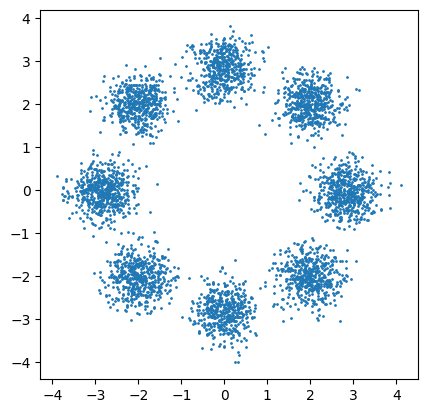

In [3]:
data_sample = gen_data(2 ** 12)

plt.scatter(data_sample[:, 0], data_sample[:, 1], s=1)
plt.axis("scaled")
plt.show()

In [4]:
class Net(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.SELU(),
            nn.Linear(64, 64),
            nn.SELU(),
            nn.Linear(64, 64),
            nn.SELU(),
            nn.Linear(64, 64),
            nn.SELU(),
            nn.Linear(64, out_dim),
        )
        
    def forward(self, t):
        return self.net(t)

In [5]:
class Affine(nn.Module):
    """
    Affine transformation module. It parametrizes the forward
    process of the diffusion model with a Gaussian distribution.

    F(x, t, eps) = \mu(x, t) + \sigma(x, t) * eps
    """

    def __init__(self):
        super().__init__()
        
        #the net used to predict the mean and std_bar in the gaussian parameterization
        self.net = Net(3, 4)
        
    def forward(self, x, t):
        # Conditional optimal transport (FM-OT)
        output1 = (1 - t) * x
        output2 = t + (1 - t) * 0.01
        #print(output1.requires_grad)
        #print(output2.requires_grad)
        return output1, output2

        # Learnable Gaussian forward process (NFDM-Gaussian)
        x_t = torch.cat([x, t], dim=1)
        m_ls = self.net(x_t) 
        m, ls = m_ls.chunk(2, dim=1)

        
        #print("m: ", m.shape)
        #print("ls: ", ls.shape)
        #print("x: ", x.shape)
        #print("t: ", t.shape)
        #print("mul", (1 - t) * x)
        #print("mul2", t * (1 - t) * m)

        m = (1 - t) * x + t * (1 - t) * m #m is mu_hat
        ls = (1 - t) * np.log(0.01) + t * (1 - t) * ls #ls is log(sigma_hat) so the final expresion is log sigma. 
        #0.01 is delta, so delta^2 = 0.0001 like in the paper

        return m, torch.exp(ls)

In [6]:
from abc import ABC, abstractmethod
from typing import Tuple
from torch import Tensor
class Gamma(nn.Module, ABC):
    @staticmethod
    def alpha_2(g):
        return torch.sigmoid(-g)

    @staticmethod
    def sigma_2(g):
        return torch.sigmoid(g)

    @abstractmethod
    def get_gamma(self, t: Tensor) -> Tensor:
        raise NotImplementedError

class GammaMuLAN(Gamma):
    #implement get_gamma and forward methods

    def __init__(self, config):
        super().__init__()
        self.config = config
        
        self.gamma_shape = config.gamma_shape
        self.n_features = config.seq_len * config.embedding_dim #what does this reflect? -> n flattend features 
        self.min_gamma = self.config.gamma_min
        self.max_minus_min_gamma = self.config.gamma_max - self.config.gamma_min
        self.grad_min_epsilon = 0.001



        #self.l1 = nn.Linear(self.n_features, self.n_features)
        #if I want the noise injection to not depend on the input, more like vdm, since input dependence will be injected through ndm function transformation, I can just make the input of
        #l1 to be 1. which means the input is just the time t. That is not fully equal to MuLAN since there the a, b, d are dependent only on input not on t.
        #that also mean I will still need to implement the get_gamma method, but not the forward method, we need tdir still. 
        self.l1 = nn.Linear(2, self.n_features)
        self.l2 = nn.Linear(self.n_features, self.n_features)
        self.l3_a = nn.Linear(self.n_features, self.n_features)
        self.l3_b = nn.Linear(self.n_features, self.n_features)
        self.l3_c = nn.Linear(self.n_features, self.n_features)

    def _eval_polynomial(self, a, b, c, t):
        # Polynomial evaluation
        polynomial = (
            (a ** 2) * (t ** 5) / 5.0
            + (b ** 2 + 2 * a * c) * (t ** 3) / 3.0
            + a * b * (t ** 4) / 2.0
            + b * c * (t ** 2)
            + (c ** 2 + self.grad_min_epsilon) * t)
        
        scale = ((a ** 2) / 5.0
                 + (b ** 2 + 2 * a * c) / 3.0
                 + a * b / 2.0
                 + b * c
                 + (c ** 2 + self.grad_min_epsilon))

        return self.min_gamma + self.max_minus_min_gamma * polynomial / scale
    
    def _grad_t(self, a, b, c, t):
        # derivative = (at^2 + bt + c)^2
        polynomial = (
        (a ** 2) * (t ** 4)
        + (b ** 2 + 2 * a * c) * (t ** 2)
        + a * b * (t ** 3) * 2.0
        + b * c * t * 2
        + (c ** 2 + self.grad_min_epsilon))
        
        scale = ((a ** 2) / 5.0
                + (b ** 2 + 2 * a * c) / 3.0
                + a * b / 2.0
                + b * c
                + (c ** 2 + self.grad_min_epsilon))

        return self.max_minus_min_gamma * polynomial / scale

    def _compute_coefficients(self, x):
        _h = torch.nn.functional.silu(self.l1(x))
        _h = torch.nn.functional.silu(self.l2(_h))
        a = self.l3_a(_h)
        b = self.l3_b(_h)
        c = 1e-3 + torch.nn.functional.softplus(self.l3_c(_h))
        #print(a,b,c)
        return a, b, c
    
    def get_gamma(self, t, x):
        a, b, c = self._compute_coefficients(x)
        gamma_flat = self._eval_polynomial(a, b, c, t)
        #shape should be bs=t.shape[0], gamma_shape
        #how do I append a value to the shape though?
        
        gamma = gamma_flat.view(-1, *self.gamma_shape)
        #print(gamma.shape, "gamma shape")
        return gamma
    
    def forward(self, t, x):
        a, b, c = self._compute_coefficients(x)
        dg = self._grad_t(a, b, c, t)
        dg = dg.clamp(min=self.grad_min_epsilon)
        return self.get_gamma(t, x), dg
#import simplenamespace from correct location
from types import SimpleNamespace
class Affine2(nn.Module):
    """
    Affine transformation module. It parametrizes the forward
    process of the diffusion model with a Gaussian distribution.

    F(x, t, eps) = \mu(x, t) + \sigma(x, t) * eps
    """

    def __init__(self):
        super().__init__()
        
        #the net used to predict the mean and std_bar in the gaussian parameterization
        self.net = Net(2, 2)
        config = SimpleNamespace(
                gamma_shape=(2,),
                seq_len= 1,
                embedding_dim= 2,#2
                gamma_min= -10, #-13.3
                gamma_max= 10, # 5
                learn_tau=False,
                learn_delta=False
            )
        self.gamma = GammaMuLAN(config)
        
    def forward(self, x, t):

        trans = self.net(x)
        gamma = self.gamma.get_gamma(t, trans)
        alpha = self.gamma.alpha_2(gamma) **0.5
        sigma = self.gamma.sigma_2(gamma) ** 0.5

        mean = alpha * x
        std = sigma

        return mean, std


In [7]:
#this class corresponds to x_theta(z_t, t), I will decouple it so that the predicted x can also be use elsewhere. in my case it will be predicted e but okay. 
class Predictor(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.net = Net(3, 2) #transformer in my case 
        
    def forward(self, z, t):
        z_t = torch.cat([z, t], dim=1)
        x = self.net(z_t)

        # Reparametrization for numerical stability
        x = (1 - t) * z + (t + 0.01) * x
        
        return x

In [8]:
class Volatility(nn.Module):
    """
    Volatility module. It parametrizes the volatility g of the reverse and forward processes.

    d z = f(z, t) d t + g(t) d \bar{w}_t
                        ^^^^
    """
    def __init__(self):
        super().__init__()
        
        self.net = Net(1, 1) #in the paper this is a three layer MLP 
        self.sp = nn.Softplus()
        
    def forward(self, t):
        # Volatility, that corresponds to linear log-SNR schedule in DDPM/VDM
        # return (20 * torch.sigmoid(-10 + 20 * t)) ** 0.5 #use this for fixed volatility

        # Learnable volatility
        return self.sp(self.net(t))

In [9]:
import torch
import torch.autograd
import torch.autograd.functional
def jvp(f, x, v):
    #copy the tensors and turn of inference mode
    with torch.inference_mode(False):
        x = x.clone()
        v = v.clone()
        return torch.autograd.functional.jvp(
            f, x, v, 
            create_graph= torch.is_grad_enabled(),
            strict=False #True
        )

def t_dir(f, t):
    return jvp(f, t, torch.ones_like(t))

In [10]:
class NeuralDiffusion(nn.Module):
    def __init__(self, affine, pred, vol):
        super().__init__()
        
        self.affine = affine
        self.pred = pred
        self.vol = vol
        
    def forward(self, x, t):
        def f(x_in):
            def f_(t_in):
                return self.affine(x_in, t_in)
            return f_

        g2 = self.vol(t) ** 2

        # compute parameters of q(z_t | x) and corresponding time derivatives
        
        #t.requires_grad = True
        #print(t.requires_grad, "t requires grad")


        (f_m, f_s), (f_dm, f_ds) = t_dir(f(x), t) #(function output), (jvp) == (mean, sigma), (mean derivative, sigma derivative)
        
        #print((f_ds == 0).sum())
        #print(f_dm)
        #print("f")
        #print(f_m.requires_grad, "f_m")
        #print(f_s.requires_grad)
        #print(f_dm.grad_fn)
        #print(f_ds.grad_fn)

        # sample z_t from q(z_t | x)
        # z_t should obtained from putting epsilon into the forward process
        eps = torch.randn_like(x)
        z = f_m + f_s * eps # function evaluation of F(x, t, eps)

        # compute the drift term of the forward process based on eps
        # f_drift is what is then used in the loss and is the forward process drift.
        f_dz = f_dm + f_ds * eps  # ODE drift ---> this works because gaussians are nice and linear so the derivative of F(x, t, eps) can be written like this. 
        f_score = - eps / f_s  # score function score of a guassian 
        f_drift = f_dz - 0.5 * g2 * f_score  # SDE drift 

        # predict x from z_t
        x_ = self.pred(z, t)

        # substitute predicted \hat{x} into the forward process to parameterise the reverse process
        (r_m, r_s), (r_dm, r_ds) = t_dir(f(x_), t)
        #print(t_dir(f(x_), torch.zeros_like(t)))
        #print(t_dir(f(x_), torch.ones_like(t)))

        #print("r")
        #print(r_m.requires_grad, "r_m")
        #print(r_s.requires_grad)
        #print(r_dm.grad_fn)
        #print(r_ds.grad_fn)


        # compute the drift term of the reverse process based on z_t
        r_dz = r_dm + r_ds / r_s * (z - r_m)  # ODE drift
        r_score = (r_m - z) / r_s ** 2  # score function
        r_drift = r_dz - 0.5 * g2 * r_score  # SDE drift

        # compute the diffusion loss
        loss = 0.5 * (f_drift - r_drift) ** 2 / g2
        loss = loss.sum(dim=1) #mean over block_size or like actual sequence. 
        # language modelling
        
        return loss

In [11]:
def train(model):
    optim = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    wandb.init(project="public_diffusion")
    pbar = trange(10 ** 5)
    for i in pbar: #10**5
        x = torch.tensor(gen_data(2 ** 10))
        t = torch.rand(x.shape[0], 1) #sample a t for each example in the batch
        
        loss = model(x, t).mean()
        
        if (i + 1) % 100 == 0:
            pbar.set_description(f"{loss.item():.4f}")
            
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        wandb.log({"loss": loss.item()})
        #put the loss on the tqdm bar
        

In [12]:
affine = Affine2()
pred = Predictor()
vol = Volatility()
ndm = NeuralDiffusion(affine, pred, vol)

In [13]:
train(ndm)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: nmidavaine (nmidavaine-university-of-amsterdam) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


10.4862:  19%|█▉        | 19460/100000 [10:35<43:51, 30.60it/s]  


KeyboardInterrupt: 

In [14]:
wandb.finish()

loss,█▇▇▇▅▅▅▄▃▃▃▃▂▂▃▃▃▂▃▂▂▂▃▂▂▂▂▂▃▂▂▂▂▂▂▂▂▁▂▂
loss,10.56652


In [15]:
@torch.no_grad()
def solve_sde(sde, z, ts, tf, n_steps):
    bs = z.shape[0]
    
    tt = torch.linspace(ts, tf, n_steps + 1)[:-1]
    dt = (tf - ts) / n_steps
    dt_2 = abs(dt) ** 0.5
    
    path = [z]
    for t in tqdm(tt):
        t = t.expand(bs, 1)
        
        f, g = sde(z, t)
        w = torch.randn_like(z)
        z = z + f * dt + g * w * dt_2
        
        path.append(z)
        
    return z, torch.stack(path)

  2%|▏         | 6/300 [00:00<00:05, 53.98it/s]

100%|██████████| 300/300 [00:04<00:00, 65.96it/s]


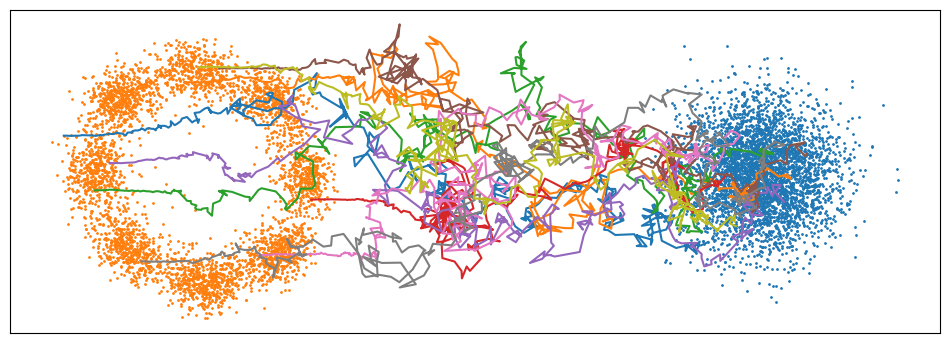

In [16]:
def sde_drift(z, t):
    x = pred(z, t)

    def f(t_in):
        return affine(x, t_in)

    (m, s), (dm, ds) = t_dir(f, t)
    g = vol(t)
    g2 = g ** 2

    dz = dm + ds / s * (z - m)
    score = (m - z) / s ** 2
    drift = dz - 0.5 * g2 * score

    return drift, g

z_1 = torch.randn(2 ** 12, 2)
_, z_path = solve_sde(sde_drift, z_1, 1, 0, 300)

t_steps = torch.linspace(1, 0, 301)

plt.figure(figsize=(12, 12))
plt.scatter(15 + z_path[0, :, 0], z_path[0, :, 1], s=1)
plt.scatter(z_path[-1, :, 0], z_path[-1, :, 1], s=1)
plt.plot(15 * t_steps[:, None] + z_path[:, :9, 0], z_path[:, :9, 1])
plt.axis("scaled")
plt.tick_params(left=False, labelleft=False,
                bottom=False, labelbottom=False)
plt.show()

100%|██████████| 300/300 [00:03<00:00, 94.71it/s] 


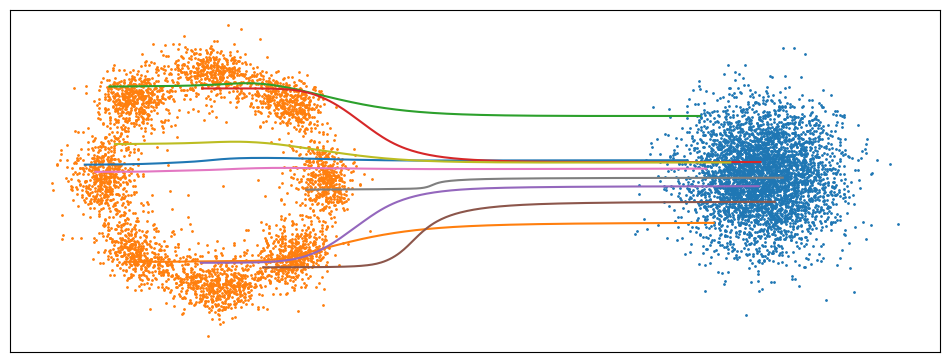

In [17]:
def ode_drift(z, t):
    x = pred(z, t)

    def f(t_in):
        return affine(x, t_in)

    (m, s), (dm, ds) = t_dir(f, t)

    dz = dm + ds / s * (z - m)

    return dz, 0

z_1 = torch.randn(2 ** 12, 2)
_, z_path = solve_sde(ode_drift, z_1, 1, 0, 300)

t_steps = torch.linspace(1, 0, 301)

plt.figure(figsize=(12, 12))
plt.scatter(15 + z_path[0, :, 0], z_path[0, :, 1], s=1)
plt.scatter(z_path[-1, :, 0], z_path[-1, :, 1], s=1)
plt.plot(15 * t_steps[:, None] + z_path[:, :9, 0], z_path[:, :9, 1])
plt.axis("scaled")
plt.tick_params(left=False, labelleft=False,
                bottom=False, labelbottom=False)
plt.show()

In [47]:
import torch
import numpy as np
from scipy import integrate

def to_flattened_numpy(x):
  """Flatten a torch tensor `x` and convert it to numpy."""
  return x.detach().cpu().numpy().reshape((-1,))


def from_flattened_numpy(x, shape):
  """Form a torch tensor with the given `shape` from a flattened numpy array `x`."""
  return torch.from_numpy(x.reshape(shape))


def get_div_fn(fn):
  """Create the divergence function of `fn` using the Hutchinson-Skilling trace estimator.
     Computes nabla f_thingy(x) i think, using the 
  """

  def div_fn(x, t, eps):
    with torch.enable_grad():
      x.requires_grad_(True)
      fn_eps = torch.sum(fn(x, t) * eps)
      grad_fn_eps = torch.autograd.grad(fn_eps, x)[0]
    x.requires_grad_(False)
    return torch.sum(grad_fn_eps * eps, dim=tuple(range(1, len(x.shape))))

  return div_fn

def get_prob_flow_ode_drift(z, t):
    x = pred(z, t)

    def f(t_in):
        return affine(x, t_in)

    (m, s), (dm, ds) = t_dir(f, t)

    dz = dm + ds / s * (z - m)
    return dz

def div_fn(x, t, noise):
    return get_div_fn(lambda xx, tt: get_prob_flow_ode_drift(xx, tt))(x, t, noise)

def get_prior_logp(z):
    """
    Computes the log density of z under a standard Gaussian.
    
    Args:
      z (torch.Tensor): A tensor of shape [batch_size, ...] representing the latent codes.
    
    Returns:
      log_prob (torch.Tensor): A tensor of shape [batch_size] with the log probability for each sample.
    """
    # Flatten z except for the batch dimension
    z_flat = z.view(z.shape[0], -1)
    d = z_flat.shape[1]  # dimensionality of the latent space
    
    # Compute the squared L2 norm of z for each sample in the batch
    norm_sq = torch.sum(z_flat ** 2, dim=1)
    
    # Compute log probability using the formula for a standard Gaussian
    log_prob = -0.5 * (d * torch.log(torch.tensor(2 * np.pi, dtype=z.dtype)) + norm_sq)
    
    return log_prob


def get_likelihood_fn(hutchinson_type='Rademacher',
                      rtol=1e-5, atol=1e-5, method='RK45', eps=1e-5):

    def likelihood_fn(data):
        """Compute an unbiased estimate to the log-likelihood in bits/dim.

        Args:
        data: A PyTorch tensor.

        Returns:
        bpd: A PyTorch tensor of shape [batch size]. The log-likelihoods on `data` in bits/dim.
        z: A PyTorch tensor of the same shape as `data`. The latent representation of `data` under the
            probability flow ODE.
        nfe: An integer. The number of function evaluations used for running the black-box ODE solver.
        """
        with torch.no_grad():
            shape = data.shape
            if hutchinson_type == 'Gaussian':
                epsilon = torch.randn_like(data)
            elif hutchinson_type == 'Rademacher':
                epsilon = torch.randint_like(data, low=0, high=2).float() * 2 - 1.
            else:
                raise NotImplementedError(f"Hutchinson type {hutchinson_type} unknown.")
            
            #the point of this is to set up the joint ode, so that means it should include both the drift ode and the logp ode.
            #since we need both of these jointly. 

            def ode_func(t, x):
                #idk if this line is correct 
                sample = from_flattened_numpy(x[:-shape[0]], shape).to(data.device).type(torch.float32)
                vec_t = (torch.ones(sample.shape[0], device=sample.device) * t).unsqueeze(-1) #I added the unsqueeze
                #print(vec_t.shape)
                #print(x.shape)

                # get the drift 
                drift = to_flattened_numpy(get_prob_flow_ode_drift(sample, vec_t))
                #get the logp_gradient 
                logp_grad = to_flattened_numpy(div_fn(sample, vec_t, epsilon))
                print("drift", drift)     
                print("logp_grad", logp_grad)
                return np.concatenate([drift, logp_grad], axis=0)

            init = np.concatenate([to_flattened_numpy(data), np.zeros((shape[0],))], axis=0)
            solution = integrate.solve_ivp(ode_func, (eps, 1), init, rtol=rtol, atol=atol, method=method)
            nfe = solution.nfev
            zp = solution.y[:, -1]
            t = solution.t[-1]
            print(t)
            z = from_flattened_numpy(zp[:-shape[0]], shape).to(data.device).type(torch.float32)
            delta_logp = from_flattened_numpy(zp[-shape[0]:], (shape[0],)).to(data.device).type(torch.float32)

            #compute the prior logp
            #In our case.....
            print("Mean of z:", z.mean().item(), "Std of z:", z.std().item(), "is the final z guassian noise?")
            prior_logp = get_prior_logp(z)
            print(prior_logp, "prior logp")
            print(delta_logp, "delta logp")
            
            bpd = -(prior_logp + delta_logp) / np.log(2)
            N = np.prod(shape[1:])
            bpd = bpd / N
            # A hack to convert log-likelihoods to bits/dim -> this line makes no sense. I think its a typo or something
            #inverse scalar is somethign we would need if we would scale the datapoints or embeddings in any way. 
            #but we do not do that.
            #offset = 7. - inverse_scaler(-1.)
            #bpd = bpd + offset
            return bpd, z, nfe
        
    return likelihood_fn


likelihood_fn = get_likelihood_fn()

x = torch.tensor(gen_data(2 ** 10))
bpd, z, nfe = likelihood_fn(x)
print("bpd is", bpd, "with shape", bpd.shape, "the mean is", bpd.mean())
print("nfes", nfe)
print(2 ** 10)

drift [ 0.11323655 -0.00527189 -0.17216761 ... -0.17342663  0.12163066
 -0.11775733]
logp_grad [-0.12162189 -0.13400109 -0.09185292 ... -0.10820596 -0.13354507
 -0.1312063 ]
drift [ 0.01460471  0.09533545 -0.02134929 ... -0.12827186 -0.01063867
 -0.03087406]
logp_grad [ 0.23715752 -0.24753988 -0.04221654 ... -0.05534643  0.14634913
  0.15694112]
drift [-0.01323448 -0.00355113 -0.05912338 ... -0.07377695  0.02725233
 -0.03274637]
logp_grad [-0.04029173 -0.05125199  0.00210701 ... -0.02926397 -0.028818
 -0.07421078]
drift [-0.04502935 -0.00097397 -0.04158345 ... -0.05772479  0.0006924
 -0.01600977]
logp_grad [-0.01197223 -0.02134688  0.01253235 ... -0.00125216  0.00106342
 -0.0648578 ]
drift [-0.01837701 -0.00142109 -0.03394493 ... -0.07712789 -0.01086465
  0.00556155]
logp_grad [ 0.1908238   0.08577785 -0.06750146 ...  0.12207711 -0.03726903
  0.07928908]
drift [-0.01220538  0.00203625 -0.03331781 ... -0.08757689 -0.00274247
  0.00678496]
logp_grad [ 0.2003805   0.10613969 -0.02687916 .